In [56]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [57]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1.4]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'],'o-')
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %s"%self.opt_param_list_name[k])
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %s"%self.opt_param_list_name[k])
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %s"%self.opt_param_list_name[k])
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [58]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list_i200_p200.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [59]:
test.run(50) # n runs in parallel (the cpu time might not be trustful)
#test.runOneByOne(50)

----finished----alg: DE_best_1_bin
----finished----alg: DE_rand_1_bin
----finished----alg: DE_randbest_1_bin
----finished----alg: DE_best_2_bin
----finished----alg: DE_rand_2_bin
----finished----alg: GA
----finished----alg: DE_best_1_exp
----finished----alg: DE_rand_1_exp
----finished----alg: DE_randbest_1_exp
----finished----alg: DE_best_2_exp
----finished----alg: DE_rand_2_exp
----finished----alg: PSO
----finished----alg: SCA
----finished----alg: BA
----finished----alg: DBA
----finished----alg: ALO


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [60]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
154,0,1,50,30,-512,512.000,1112.630,425.869,1963.520,1032.760,10035.200,371.460,2334.980
280,1,1,50,30,-512,512.000,818.031,267.976,1300.190,787.147,7595.310,130.740,1430.930
226,2,1,50,30,-512,512.000,1257.490,244.199,1095.100,1264.930,7729.950,670.149,1765.250
85,3,1,50,30,-512,512.000,5349.210,369.932,1602.810,5418.060,8152.110,4296.790,5899.610
44,4,1,50,30,-512,512.000,1696.720,381.531,1803.250,1686.040,8035.520,770.581,2573.830
220,5,1,50,30,-512,512.000,118.620,103.088,386.705,86.027,8033.130,10.714,397.419
158,6,1,50,30,-512,512.000,1959.070,311.829,1300.480,2013.070,5895.180,1253.610,2554.090
86,7,1,50,30,-512,512.000,6247.280,405.079,2020.960,6281.270,7553.510,4940.840,6961.800
177,8,1,50,30,-512,512.000,5538.660,1024.480,4376.140,5714.940,8877.730,2728.880,7105.030
234,9,1,50,30,-512,512.000,1922.260,314.668,1510.540,1950.680,8827.250,1138.850,2649.390


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

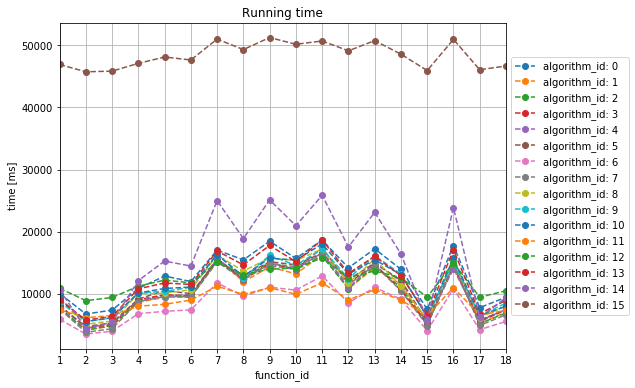

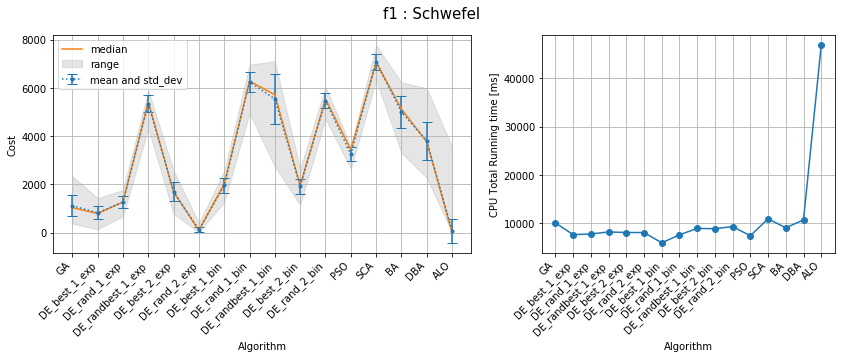

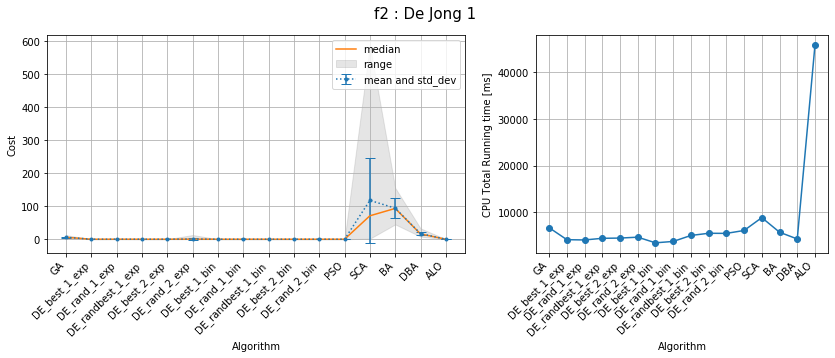

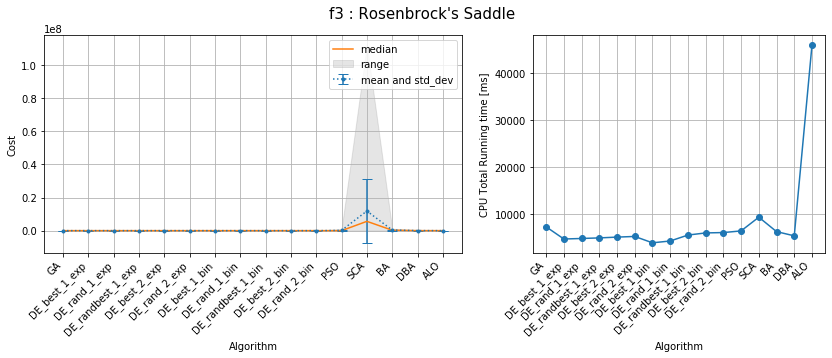

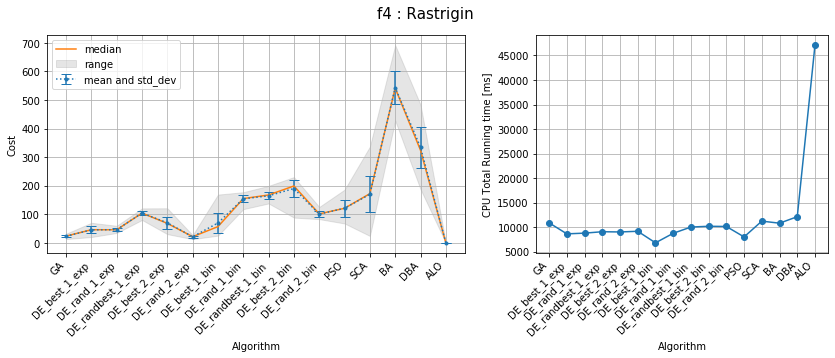

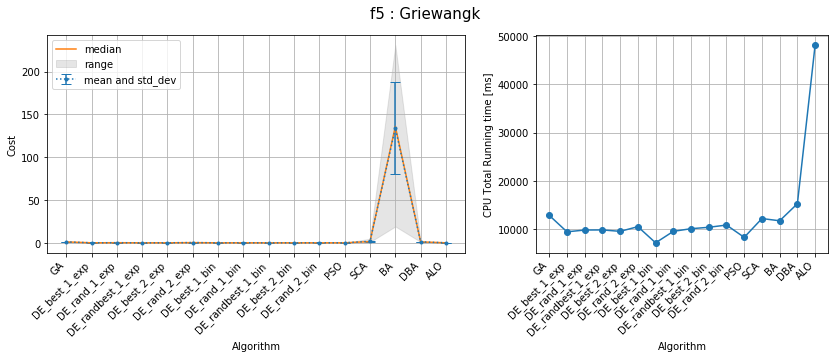

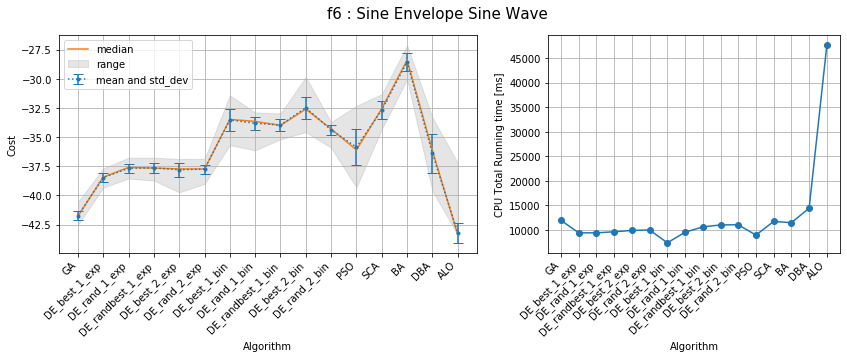

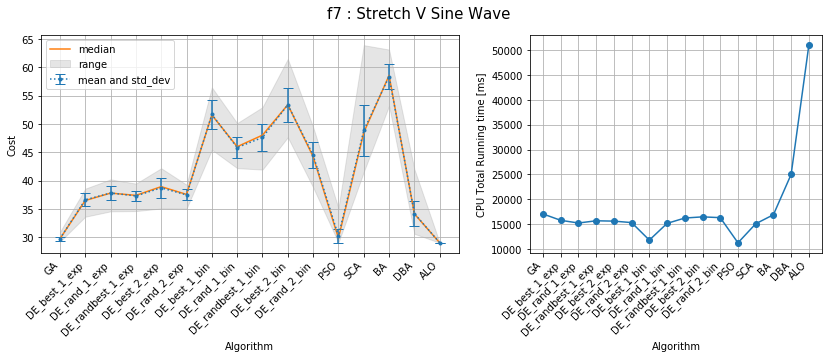

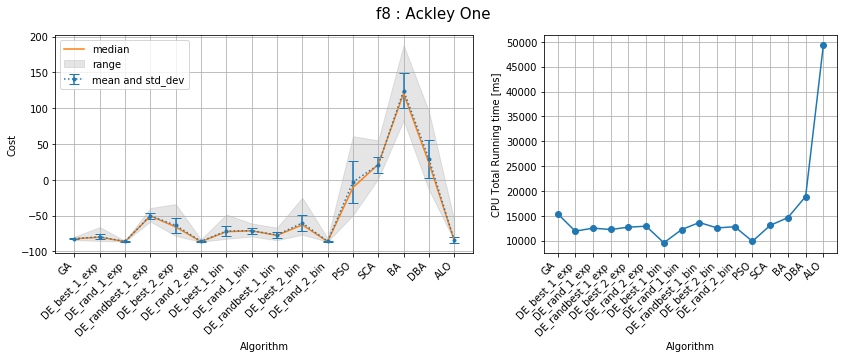

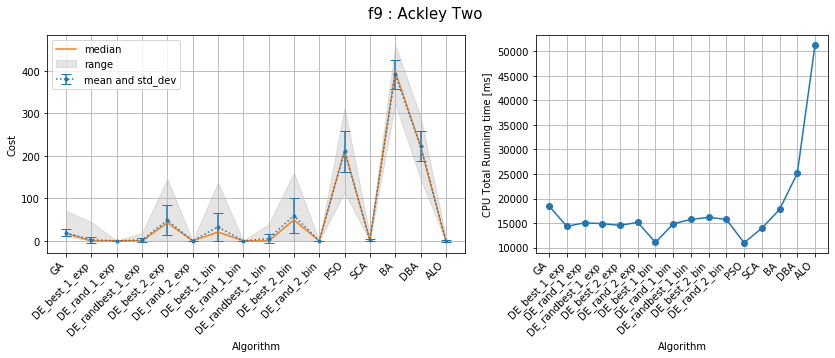

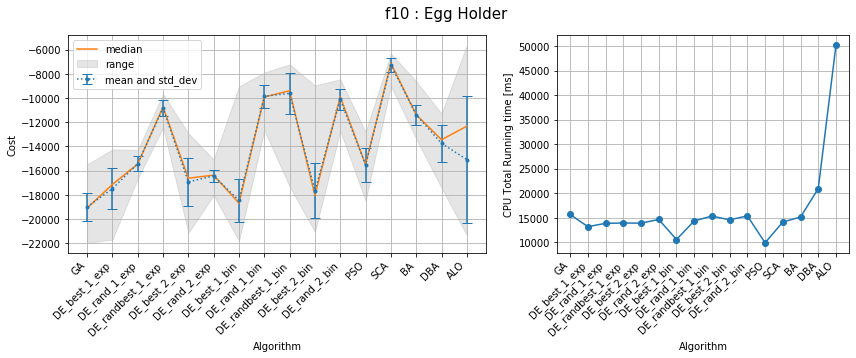

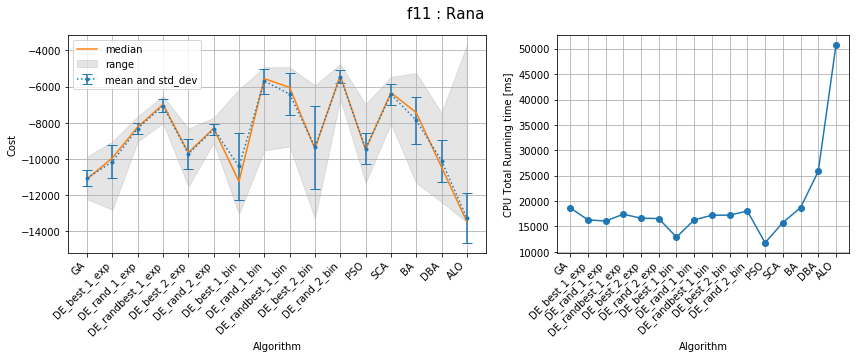

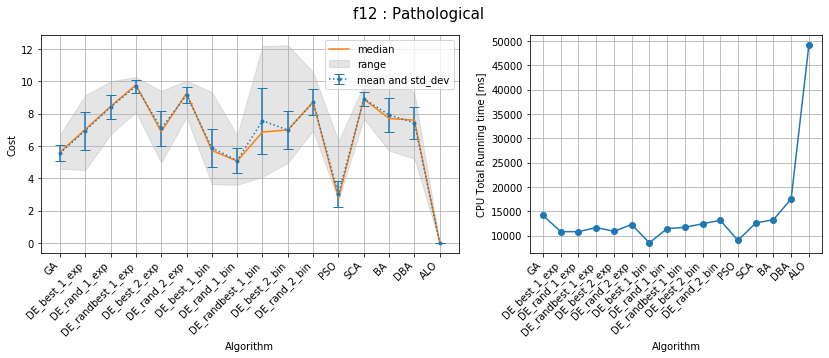

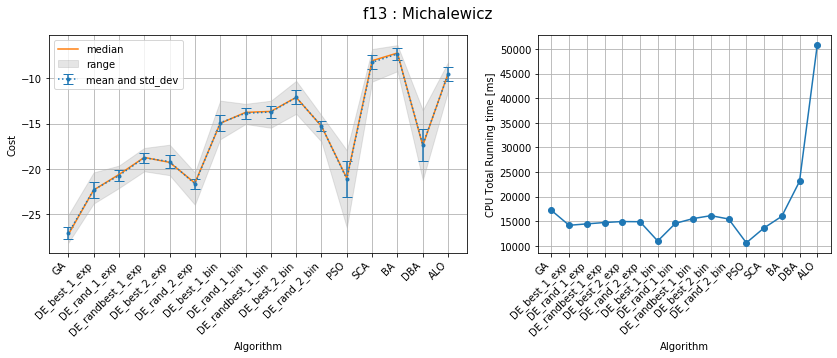

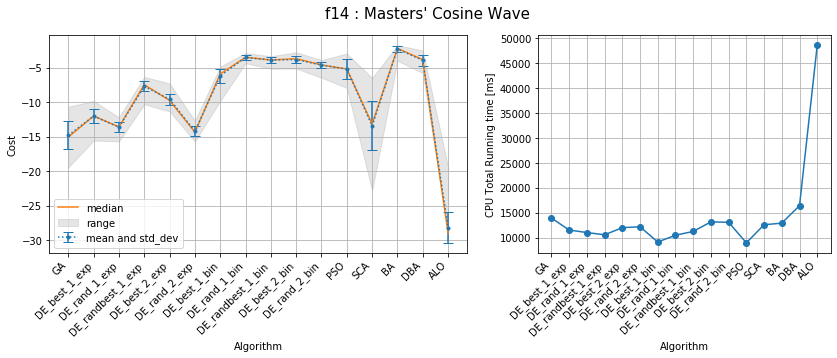

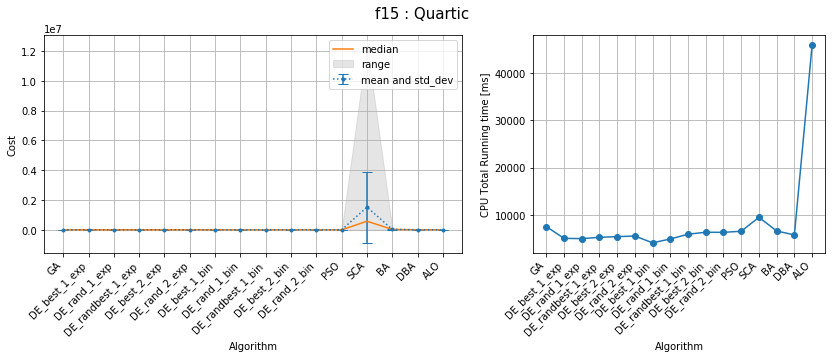

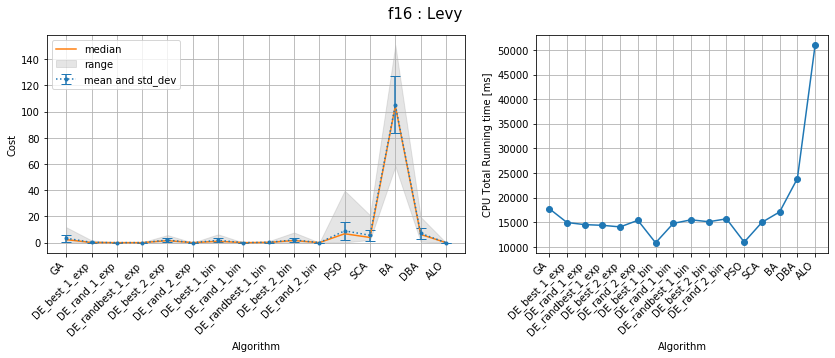

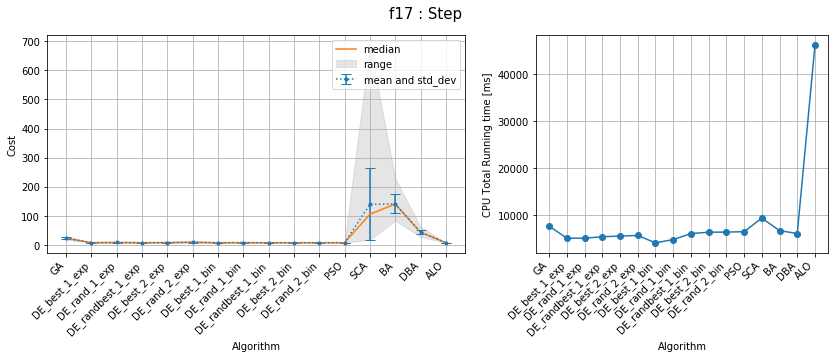

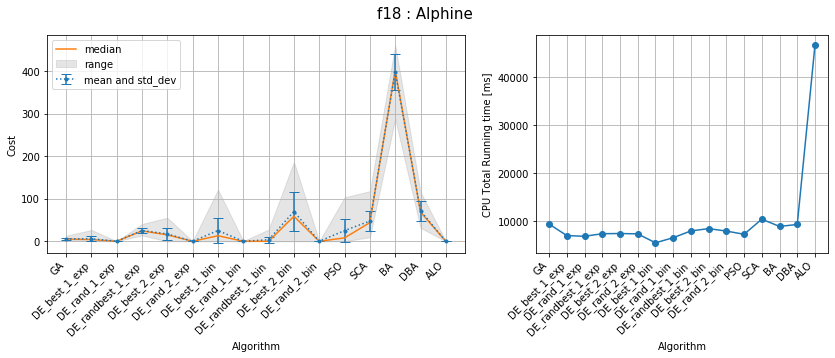

In [61]:
test.plot()

In [62]:


pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
154,0,1,50,30,-512,512.000,1112.630,425.869,1963.520,1032.760,10035.200,371.460,2334.980
54,0,2,50,30,-100,100.000,5.892,1.885,9.451,5.899,6731.500,2.895,12.346
246,0,3,50,30,-100,100.000,2793.560,2505.980,11229.100,2062.810,7357.580,694.435,11923.600
24,0,4,50,30,-30,30.000,23.149,3.064,18.559,23.435,10859.400,13.171,31.730
134,0,5,50,30,-500,500.000,1.067,0.016,0.072,1.064,12844.200,1.037,1.109
150,0,6,50,30,-30,30.000,-41.728,0.421,1.961,-41.778,11961.100,-42.526,-40.565
237,0,7,50,30,-30,30.000,29.729,0.341,1.722,29.699,17027.300,29.182,30.904
123,0,8,50,30,-32,32.000,-82.148,1.023,4.740,-82.210,15449.700,-84.145,-79.405
252,0,9,50,30,-32,32.000,18.947,8.326,59.630,17.654,18459.700,10.799,70.430
64,0,10,50,30,-500,500.000,-19007.100,1169.460,6473.590,-19098.100,15678.900,-21971.100,-15497.500


In [63]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
154,0,1,50,30,-512,512.000,1112.630,425.869,1963.520,1032.760,10035.200,371.460,2334.980
280,1,1,50,30,-512,512.000,818.031,267.976,1300.190,787.147,7595.310,130.740,1430.930
226,2,1,50,30,-512,512.000,1257.490,244.199,1095.100,1264.930,7729.950,670.149,1765.250
85,3,1,50,30,-512,512.000,5349.210,369.932,1602.810,5418.060,8152.110,4296.790,5899.610
44,4,1,50,30,-512,512.000,1696.720,381.531,1803.250,1686.040,8035.520,770.581,2573.830
220,5,1,50,30,-512,512.000,118.620,103.088,386.705,86.027,8033.130,10.714,397.419
158,6,1,50,30,-512,512.000,1959.070,311.829,1300.480,2013.070,5895.180,1253.610,2554.090
86,7,1,50,30,-512,512.000,6247.280,405.079,2020.960,6281.270,7553.510,4940.840,6961.800
177,8,1,50,30,-512,512.000,5538.660,1024.480,4376.140,5714.940,8877.730,2728.880,7105.030
234,9,1,50,30,-512,512.000,1922.260,314.668,1510.540,1950.680,8827.250,1138.850,2649.390


# Read solution.csv, generate plot and latex report

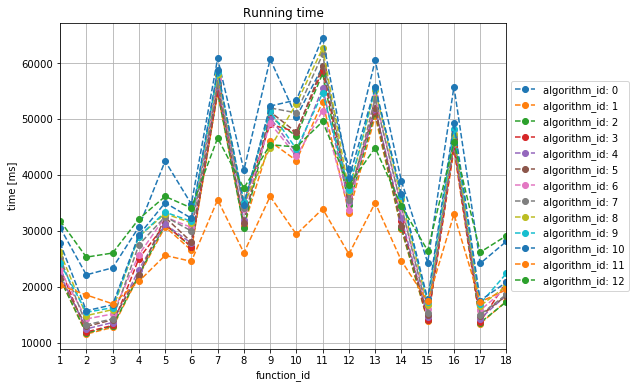

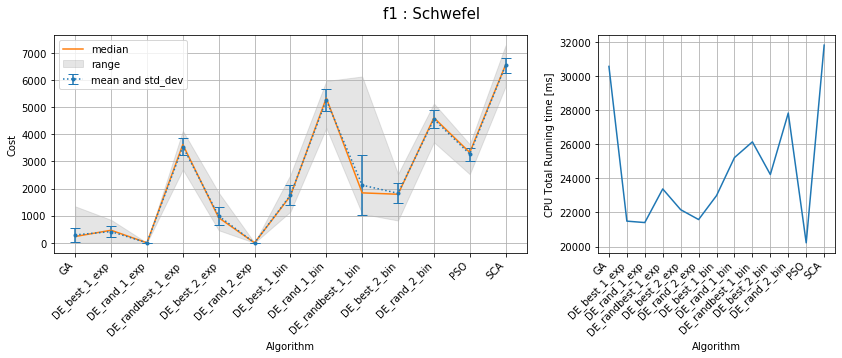

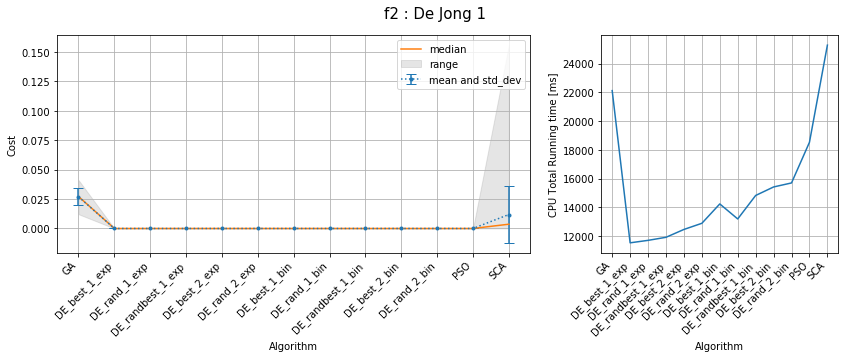

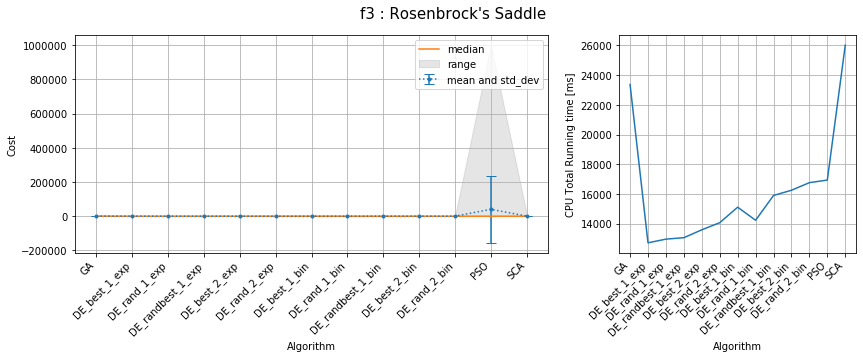

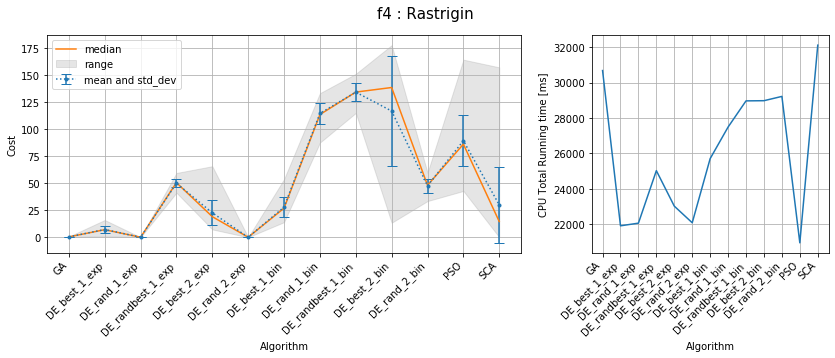

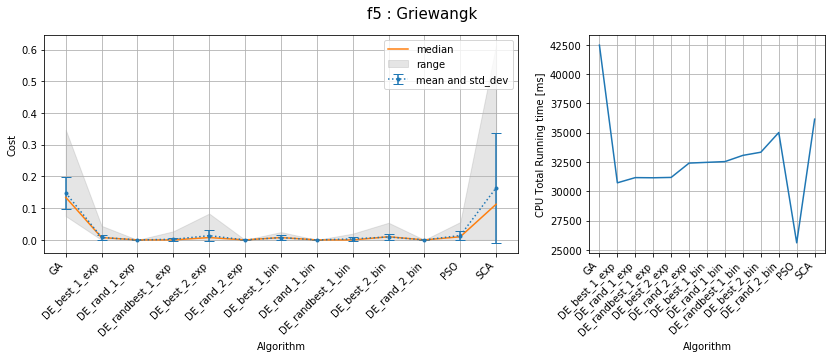

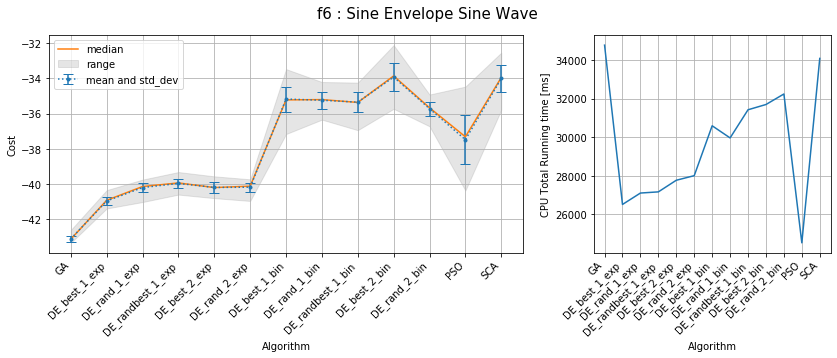

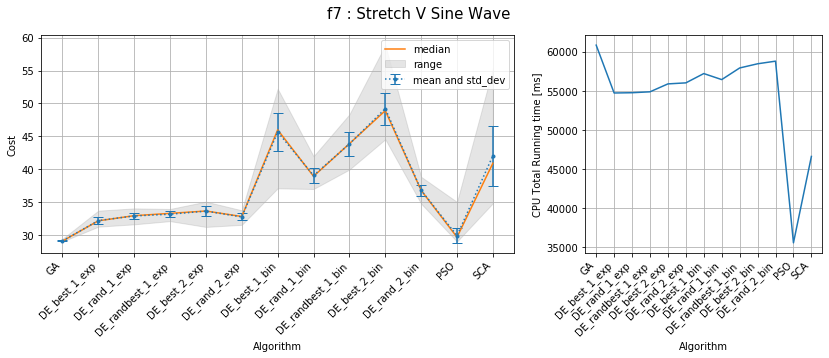

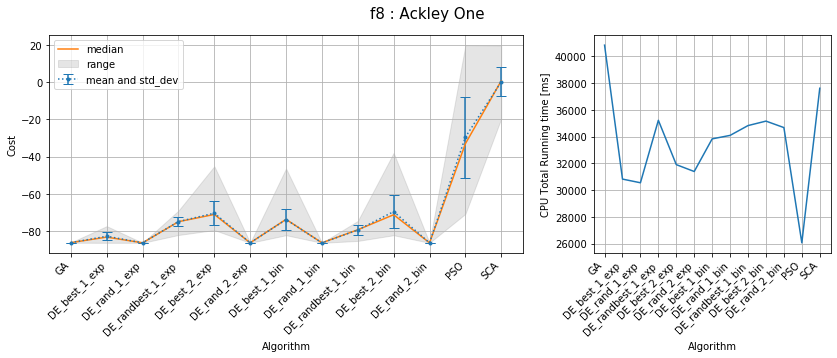

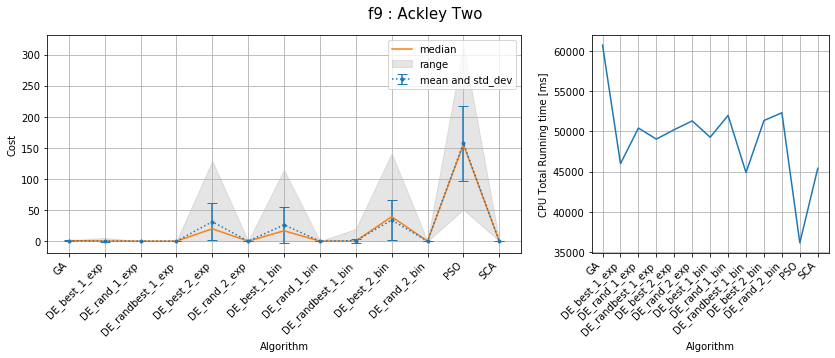

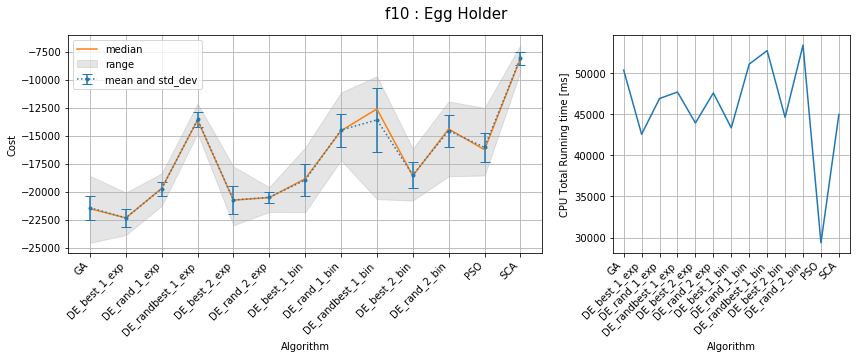

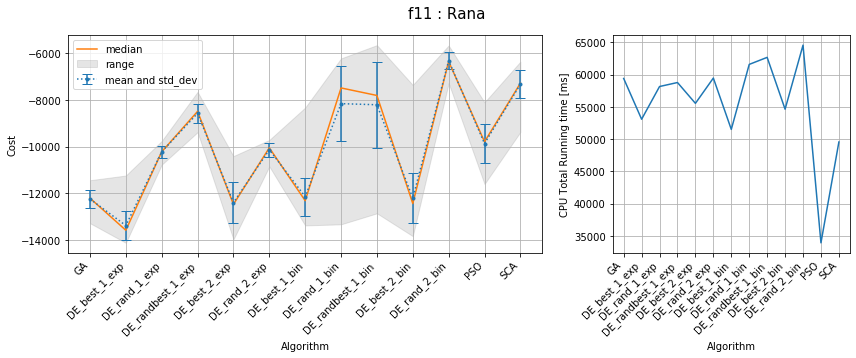

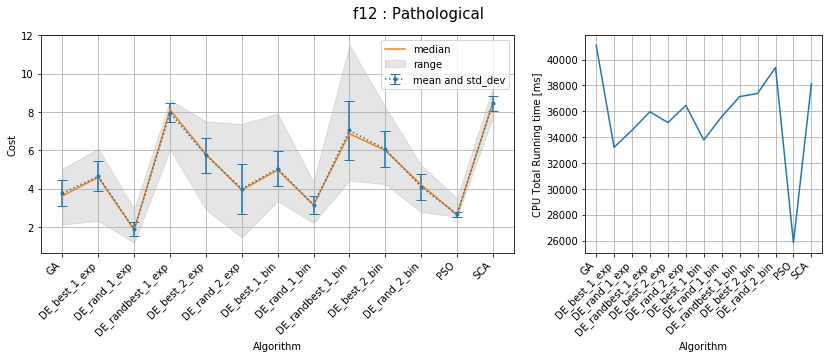

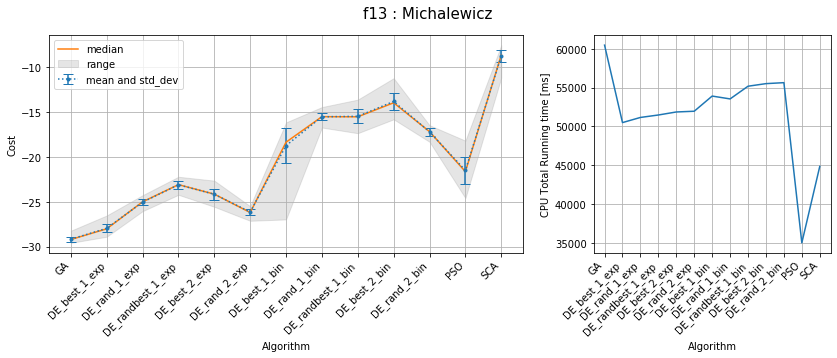

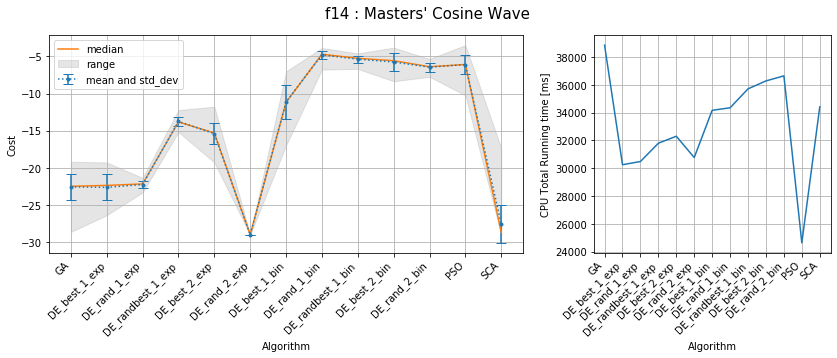

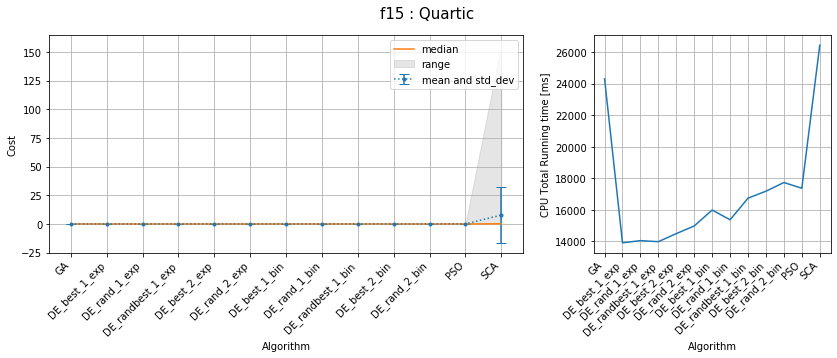

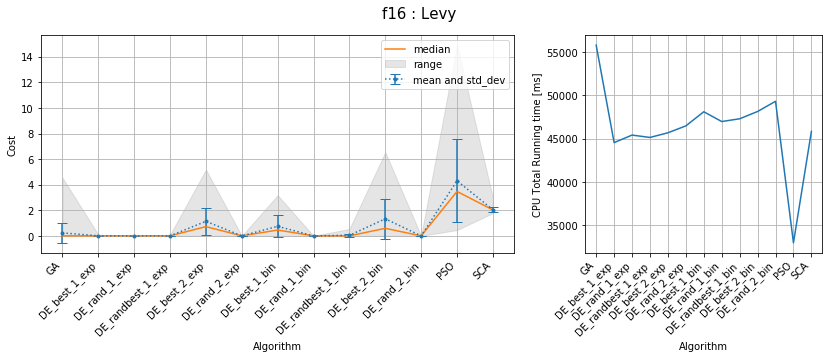

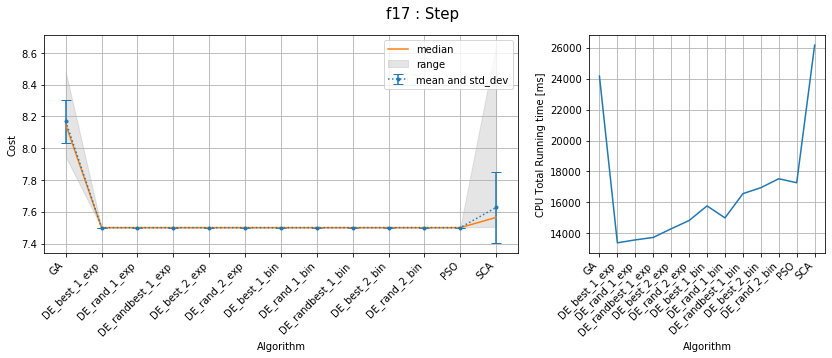

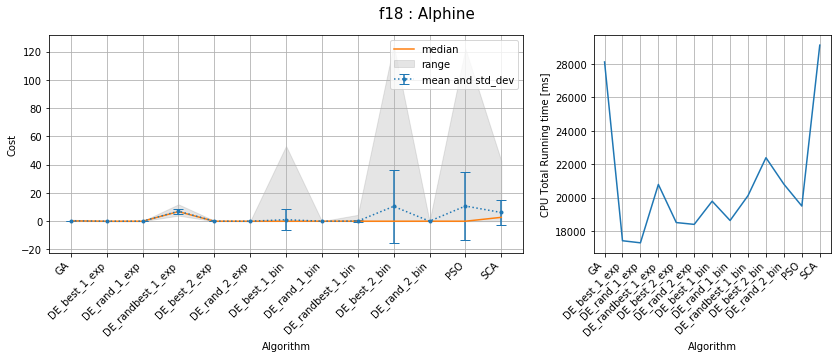

In [26]:
df=pd.read_csv("../out/optimization-linux-1cpu-500-500/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [8]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
226,1,1,50,30,-512,512.000,413.589,204.703,846.204,462.697,21489.300,-0.001,846.203
183,2,1,50,30,-512,512.000,0.001,0.001,0.003,0.001,21405.800,-0.000,0.003
67,3,1,50,30,-512,512.000,3542.440,305.624,1428.860,3618.260,23376.400,2698.730,4127.590
35,4,1,50,30,-512,512.000,987.060,321.703,1386.780,925.399,22160.100,462.703,1849.480
178,5,1,50,30,-512,512.000,-0.002,0.000,0.002,-0.002,21582.000,-0.003,-0.001
130,6,1,50,30,-512,512.000,1757.670,359.702,1355.990,1728.670,22986.300,1147.530,2503.530
68,7,1,50,30,-512,512.000,5261.550,396.785,1730.240,5335.010,25214.300,4231.200,5961.440
142,8,1,50,30,-512,512.000,2124.900,1093.450,5061.780,1840.380,26134.600,1066.570,6128.350
189,9,1,50,30,-512,512.000,1824.540,364.970,1713.930,1789.090,24220.600,821.697,2535.630


## read df

In [13]:
df=pd.read_csv("../out/optimization-linux-1cpu-500-500/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)

## support codes for latex report generation

In [64]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [65]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [66]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    print("\\newpage")    
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/figures-linux-1cpu-500-500/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize""")
    print(df_fx.to_latex(index=False))
    print("""\\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # save the good algorithms after the hypothesis testing
    good_alg = []
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    print("\\vspace{-3mm}")
                    print("\\rule[3mm]{\\linewidth}{0.2pt}")
                    print("Null hypothesis: The best algorithm and the tested one are equal\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(", P value: %f\\\\"%p)
                #print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))
                good_alg.append(row["algorithm"])
    
    return good_alg

print_latex_function(8)

\newpage
\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures-linux-1cpu-500-500/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &   time\_ms \\
\midrule
 GA & -82.148 & 1.023 & -82.210 & -84.145 & -79.405 & 15449.700 \\
 DE\_best\_1\_exp & -79.549 & 3.678 & -80.067 & -85.272 & -65.979 & 11927.600 \\
 DE\_rand\_1\_exp & -86.060 & 0.283 & -86.143 & -86.232 & -85.018 & 12523.600 \\
 DE\_randbest\_1\_exp & -50.032 & 4.022 & -50.378 & -58.158 & -39.285 & 12259.800 \\
 DE\_best\_2\_exp & -63.594 & 9.986 & -65.760 & -78.284 & -33.881 & 12727.900 \\
 DE\_rand\_2\_exp & -85.751 & 0.835 & -86.254 & -86.318 & -83.218 & 12919.700 \\
 DE\_best\_1\_bin & -71.410 & 6.780 & -72.

[]

## Print latex

In [67]:
function_list = df_s["function_id"].unique()
good_algs = []
for i in function_list:
    good_algs.append(print_latex_function(i))

\newpage
\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures-linux-1cpu-500-500/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &   time\_ms \\
\midrule
 GA & 1112.630 & 425.869 & 1032.760 & 371.460 & 2334.980 & 10035.200 \\
 DE\_best\_1\_exp & 818.031 & 267.976 & 787.147 & 130.740 & 1430.930 & 7595.310 \\
 DE\_rand\_1\_exp & 1257.490 & 244.199 & 1264.930 & 670.149 & 1765.250 & 7729.950 \\
 DE\_randbest\_1\_exp & 5349.210 & 369.932 & 5418.060 & 4296.790 & 5899.610 & 8152.110 \\
 DE\_best\_2\_exp & 1696.720 & 381.531 & 1686.040 & 770.581 & 2573.830 & 8035.520 \\
 DE\_rand\_2\_exp & 118.620 & 103.088 & 86.027 & 10.714 & 397.419 & 8033.130 \\
 DE\_best\_1\_bin & 1959.

## get algorithms with similar result comparing to the best

In [68]:
good_algs_s = [", ".join(i) for i in good_algs]
good_algs_s

['DE_rand_2_exp',
 'DE_randbest_1_bin',
 'DE_rand_2_exp',
 '',
 '',
 '',
 '',
 '',
 '',
 'DE_best_1_bin',
 '',
 '',
 '',
 '',
 'DE_best_2_exp, DE_best_1_bin, DE_rand_1_bin, DE_randbest_1_bin, DE_best_2_bin, DE_rand_2_bin, ALO',
 '',
 'DE_best_1_bin, PSO',
 '']

In [69]:
df_similar=pd.DataFrame(list(zip(function_list,good_algs_s)), columns = ['function_id','similar_result'])

# print summary table

In [70]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
154,0,1,50,30,-512,512.000,1112.630,425.869,1963.520,1032.760,10035.200,371.460,2334.980
54,0,2,50,30,-100,100.000,5.892,1.885,9.451,5.899,6731.500,2.895,12.346
246,0,3,50,30,-100,100.000,2793.560,2505.980,11229.100,2062.810,7357.580,694.435,11923.600
24,0,4,50,30,-30,30.000,23.149,3.064,18.559,23.435,10859.400,13.171,31.730
134,0,5,50,30,-500,500.000,1.067,0.016,0.072,1.064,12844.200,1.037,1.109
150,0,6,50,30,-30,30.000,-41.728,0.421,1.961,-41.778,11961.100,-42.526,-40.565
237,0,7,50,30,-30,30.000,29.729,0.341,1.722,29.699,17027.300,29.182,30.904
123,0,8,50,30,-32,32.000,-82.148,1.023,4.740,-82.210,15449.700,-84.145,-79.405
252,0,9,50,30,-32,32.000,18.947,8.326,59.630,17.654,18459.700,10.799,70.430
64,0,10,50,30,-500,500.000,-19007.100,1169.460,6473.590,-19098.100,15678.900,-21971.100,-15497.500


In [71]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[alg_id.index(str(label))]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSO,SCA,BA,DBA,ALO
0,1,1112.630,818.031,1257.490,5349.210,1696.720,118.620,1959.070,6247.280,5538.660,1922.260,5464.790,3253.400,7080.270,4994.940,3810.520,71.152
1,2,5.892,0.000,0.105,0.001,0.002,0.675,0.000,0.006,0.000,0.000,0.001,0.000,117.846,94.129,17.037,0.000
2,3,2793.560,226.672,714.642,170.952,851.988,10713.600,77.386,233.834,218.849,108.453,164.307,160886.000,11869300.000,351464.000,33449.300,1.745
3,4,23.149,45.388,45.913,104.180,69.924,21.054,69.477,153.858,164.571,190.028,100.340,121.126,169.699,543.358,334.082,0.008
4,5,1.067,0.009,0.131,0.009,0.025,0.263,0.006,0.018,0.004,0.009,0.003,0.014,1.735,133.951,1.102,0.000
5,6,-41.728,-38.472,-37.673,-37.636,-37.802,-37.743,-33.524,-33.813,-33.961,-32.482,-34.381,-35.867,-32.666,-28.552,-36.391,-43.199
6,7,29.729,36.599,37.800,37.282,38.714,37.461,51.691,45.837,47.625,53.403,44.513,30.194,48.863,58.386,34.169,29.000
7,8,-82.148,-79.549,-86.060,-50.032,-63.594,-85.751,-71.410,-70.955,-76.861,-60.138,-85.831,-2.911,20.980,124.767,29.500,-83.978
8,9,18.947,2.980,0.363,2.535,48.809,0.298,33.071,0.324,5.529,59.691,0.053,210.716,2.646,392.025,222.807,0.604
9,10,-19007.100,-17495.600,-15427.400,-10818.400,-16930.100,-16432.000,-18460.100,-9844.840,-9614.670,-17654.300,-10110.000,-15525.100,-7251.820,-11386.500,-13742.900,-15082.400


\begin{tabular}{rrrrrrrrrrrrrrrrr}
\toprule
 function\_id &         GA &  DE\_best\_1\_exp &  DE\_rand\_1\_exp &  DE\_randbest\_1\_exp &  DE\_best\_2\_exp &  DE\_rand\_2\_exp &  DE\_best\_1\_bin &  DE\_rand\_1\_bin &  DE\_randbest\_1\_bin &  DE\_best\_2\_bin &  DE\_rand\_2\_bin &        PSO &          SCA &         BA &        DBA &        ALO \\
\midrule
 1 & 1112.630 & 818.031 & 1257.490 & 5349.210 & 1696.720 & 118.620 & 1959.070 & 6247.280 & 5538.660 & 1922.260 & 5464.790 & 3253.400 & 7080.270 & 4994.940 & 3810.520 & 71.152 \\
 2 & 5.892 & 0.000 & 0.105 & 0.001 & 0.002 & 0.675 & 0.000 & 0.006 & 0.000 & 0.000 & 0.001 & 0.000 & 117.846 & 94.129 & 17.037 & 0.000 \\
 3 & 2793.560 & 226.672 & 714.642 & 170.952 & 851.988 & 10713.600 & 77.386 & 233.834 & 218.849 & 108.453 & 164.307 & 160886.000 & 11869300.000 & 351464.000 & 33449.300 & 1.745 \\
 4 & 23.149 & 45.388 & 45.913 & 104.180 & 69.924 & 21.054 & 69.477 & 153.858 & 164.571 & 190.028 & 100.340 & 121.126 & 169.699 & 543.358 & 334.082 

In [72]:
df_result

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSO,SCA,BA,DBA,ALO
0,1,1112.630,818.031,1257.490,5349.210,1696.720,118.620,1959.070,6247.280,5538.660,1922.260,5464.790,3253.400,7080.270,4994.940,3810.520,71.152
1,2,5.892,0.000,0.105,0.001,0.002,0.675,0.000,0.006,0.000,0.000,0.001,0.000,117.846,94.129,17.037,0.000
2,3,2793.560,226.672,714.642,170.952,851.988,10713.600,77.386,233.834,218.849,108.453,164.307,160886.000,11869300.000,351464.000,33449.300,1.745
3,4,23.149,45.388,45.913,104.180,69.924,21.054,69.477,153.858,164.571,190.028,100.340,121.126,169.699,543.358,334.082,0.008
4,5,1.067,0.009,0.131,0.009,0.025,0.263,0.006,0.018,0.004,0.009,0.003,0.014,1.735,133.951,1.102,0.000
5,6,-41.728,-38.472,-37.673,-37.636,-37.802,-37.743,-33.524,-33.813,-33.961,-32.482,-34.381,-35.867,-32.666,-28.552,-36.391,-43.199
6,7,29.729,36.599,37.800,37.282,38.714,37.461,51.691,45.837,47.625,53.403,44.513,30.194,48.863,58.386,34.169,29.000
7,8,-82.148,-79.549,-86.060,-50.032,-63.594,-85.751,-71.410,-70.955,-76.861,-60.138,-85.831,-2.911,20.980,124.767,29.500,-83.978
8,9,18.947,2.980,0.363,2.535,48.809,0.298,33.071,0.324,5.529,59.691,0.053,210.716,2.646,392.025,222.807,0.604
9,10,-19007.100,-17495.600,-15427.400,-10818.400,-16930.100,-16432.000,-18460.100,-9844.840,-9614.670,-17654.300,-10110.000,-15525.100,-7251.820,-11386.500,-13742.900,-15082.400


## get best cost without time

In [73]:
df_best = df_result[["function_id"]]
df_best["best_algorithm"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

/home/c/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/c/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,best_algorithm,best_cost
0,1,ALO,71.152
1,2,PSO,0.000
2,3,ALO,1.745
3,4,ALO,0.008
4,5,ALO,0.000
5,6,ALO,-43.199
6,7,ALO,29.000
7,8,DE_rand_1_exp,-86.060
8,9,DE_rand_2_bin,0.053
9,10,GA,-19007.100


In [74]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
df_best_similar = df_best.merge(df_similar, on=["function_id"], how='left') 
df_best_similar

,function_id,best_algorithm,best_cost,similar_result
0,1,ALO,71.152,DE_rand_2_exp
1,2,PSO,0.000,DE_randbest_1_bin
2,3,ALO,1.745,DE_rand_2_exp
3,4,ALO,0.008,
4,5,ALO,0.000,
5,6,ALO,-43.199,
6,7,ALO,29.000,
7,8,DE_rand_1_exp,-86.060,
8,9,DE_rand_2_bin,0.053,
9,10,GA,-19007.100,DE_best_1_bin


In [37]:
print(df_best_similar.to_latex(index=False))

\begin{tabular}{rlrl}
\toprule
 function\_id &     best\_algorithm &  best\_cost &                         similar\_result \\
\midrule
 1 &  ALO & 0.044 &   \\
 2 &  PSO & 0.001 &   \\
 3 &  ALO & 2.579 &  DE\_randbest\_1\_bin, PSO \\
 4 &  ALO & 5.612 &   \\
 5 &  DE\_best\_1\_bin & 0.014 &  DE\_randbest\_1\_bin, PSO, ALO \\
 6 &  ALO & -40.692 &  GA \\
 7 &  ALO & 29.001 &   \\
 8 &  ALO & -83.278 &   \\
 9 &  ALO & 2.561 &   \\
 10 &  GA & -18289.500 &   \\
 11 &  ALO & -13111.900 &   \\
 12 &  ALO & 0.000 &   \\
 13 &  GA & -25.973 &   \\
 14 &  ALO & -24.384 &   \\
 15 &  PSO & 0.000 &  DE\_randbest\_1\_bin, DE\_best\_2\_bin, ALO \\
 16 &  ALO & 0.009 &   \\
 17 &  DE\_randbest\_1\_bin & 7.659 &  PSO, ALO \\
 18 &  ALO & 0.056 &   \\
\bottomrule
\end{tabular}



## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
